In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Hide warning temporarily
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("data/flights_sample_2m.csv")

In [3]:
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df["YEAR"] = df["FL_DATE"].dt.year
df["MONTH"] = df["FL_DATE"].dt.month

In [4]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

# 1. Phân tích mô tả (Descriptive Analysis)
## 1.1 Tổng quan
### Số chuyến bay mỗi năm (2019-2023)

In [5]:
df_flights = df.copy()

In [6]:
flights_yearly = df_flights.groupby("YEAR")["FL_DATE"].count().reset_index(name="Total_Flights")
flights_yearly

,YEAR,Total_Flights
0,2019,505345
1,2020,318768
2,2021,407824
3,2022,457760
4,2023,310303


In [7]:
fig_flights_yearly = px.bar(flights_yearly, 
             x='YEAR', y='Total_Flights',
            title="Total number of flights per year (2019-2023)",
            color="YEAR", height=500)
fig_flights_yearly.show()

### Mỗi tháng có bao nhiêu chuyến bay?

In [8]:
flights_monthly = df_flights.groupby(["YEAR","MONTH"])["FL_DATE"].count().reset_index(name="Total_Flights")
flights_monthly

,YEAR,MONTH,Total_Flights
0,2019,1,39568
1,2019,2,35912
2,2019,3,43208
3,2019,4,41136
4,2019,5,43293
5,2019,6,43584
6,2019,7,44850
7,2019,8,45015
8,2019,9,41281
9,2019,10,43438


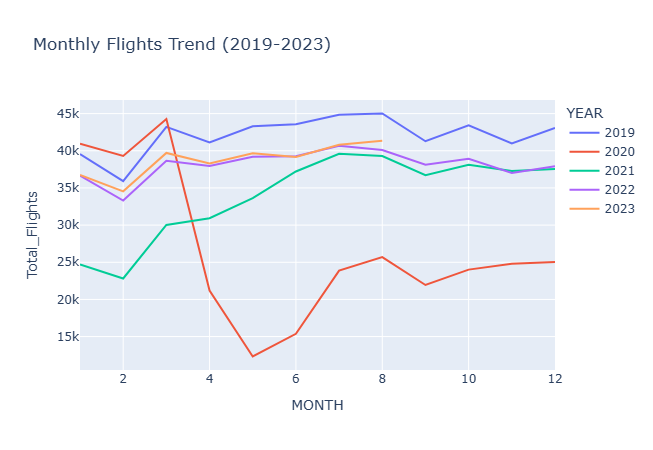

In [9]:
fig_flights_monthly = px.line(flights_monthly,
                             x='MONTH', y='Total_Flights',
                             color='YEAR',
                             title='Monthly Flights Trend (2019-2023)',
                             height=450)
fig_flights_monthly.show()

### Hãng hàng không nào có nhiều chuyến bay nhất mỗi năm?

In [10]:
# Tổng số chuyến bay theo năm và hãng
flights_airline_yearly = (
    df_flights.groupby(["YEAR", "AIRLINE"])["FL_DATE"]
    .count()
    .reset_index(name="Total_Flights")
)

# Tổng toàn ngành mỗi năm
flights_industry_total = (
    flights_airline_yearly.groupby("YEAR")["Total_Flights"]
    .sum()
    .reset_index(name="Industry_Total")
)

# Merge vào bảng hãng
flights_airline_vs_industry = flights_airline_yearly.merge(flights_industry_total, on="YEAR")

In [11]:
# Tính % thay đổi so với năm trước (tốc độ phục hồi)
flights_airline_vs_industry["Growth_Rate"] = (
    flights_airline_vs_industry.groupby("AIRLINE")["Total_Flights"]
    .pct_change() * 100
)

flights_industry_total["Industry_Growth"] = (
    flights_industry_total["Industry_Total"].pct_change() * 100
)

In [12]:
# Lấy hãng top (ví dụ: top năm 2019)
airline_top = (
    flights_airline_vs_industry[flights_airline_vs_industry["YEAR"] == 2019]
    .sort_values("Total_Flights", ascending=False)
    .iloc[0]["AIRLINE"]
)

# So sánh tốc độ phục hồi của hãng top
compare = flights_airline_vs_industry[flights_airline_vs_industry["AIRLINE"] == airline_top][["YEAR", "Growth_Rate"]].merge(flights_industry_total[["YEAR", "Industry_Growth"]], 
                                                                                                          on="YEAR"
)
print(f"Top airline: {airline_top}")
print(compare)

Top airline: Southwest Airlines Co.
   YEAR  Growth_Rate  Industry_Growth
0  2019          NaN              NaN
1  2020   -30.085404       -36.920718
2  2021    11.239175        27.937560
3  2022    22.425528        12.244498
4  2023   -27.414635       -32.212732


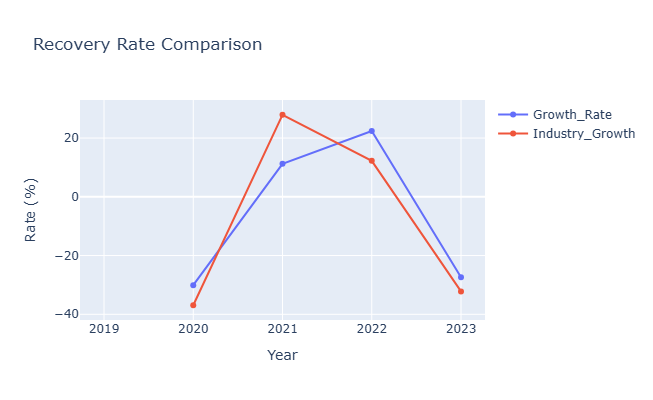

In [13]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                         x=compare['YEAR'], y=compare['Growth_Rate'],
                         mode='lines+markers', name='Growth_Rate'))
fig.add_trace(go.Scatter(
                         x=compare['YEAR'], y=compare['Industry_Growth'],
                         mode='lines+markers', name='Industry_Growth'))
fig.update_layout(
    title=dict(text='Recovery Rate Comparison'),
    xaxis=dict(title=dict(text='Year')),
    yaxis=dict(title=dict(text='Rate (%)')),
    height=400
)
fig.show()

## 1.2 Delay tổng quát
### Tỉ lệ chuyến bay bị delay (>15 phút) là bao nhiêu?

In [14]:
df_flights_delay = df.copy()

In [15]:
# tỉ lệ delay theo năm - tháng
delay_rate_yearly = (df_flights_delay.groupby(["YEAR","MONTH"])["ARR_DELAY"]
        .apply(lambda x: (x > 15).mean() * 100).round(1)
        .reset_index(name="Delay_Rate")
)

In [19]:
delay_rate_yearly

,YEAR,MONTH,Delay_Rate
0,2019,1,17.4
1,2019,2,21.8
2,2019,3,16.2
3,2019,4,17.1
4,2019,5,19.4
5,2019,6,23.2
6,2019,7,20.0
7,2019,8,19.3
8,2019,9,13.4
9,2019,10,15.7


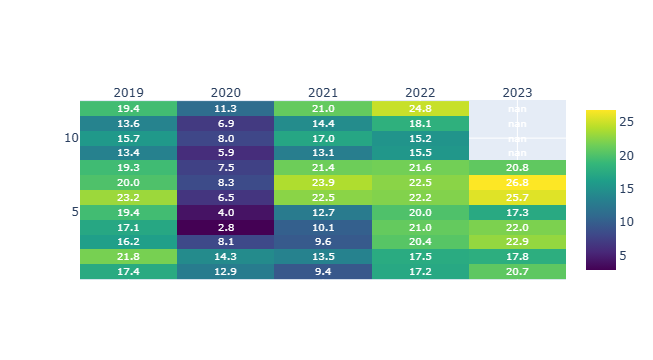

In [22]:
# Pivot dữ liệu thành dạng matrix cho heatmap
heatmap = delay_rate_yearly.pivot(index="MONTH", columns="YEAR", values="Delay_Rate")

fig = go.Figure(
    data=go.Heatmap(
        z=heatmap.values,
        x=heatmap.columns,
        y=heatmap.index,
        colorscale="Viridis")
)

# Thêm text annotation
for i, month in enumerate(heatmap.index):
    for j, year in enumerate(heatmap.columns):
        fig.add_annotation(
            x=year, y=month,
            text=str(heatmap.iloc[i, j]),
            showarrow=False,
            font=dict(color="white", size=10)
        )

fig.update_xaxes(side="top")
fig.show()

# SQL
## pandasql (Slow)

In [26]:
import pandas as pd
import pandasql as ps

In [27]:
query = "SELECT * FROM df LIMIT 5"
ps.sqldf(query, locals())

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,MONTH
0,2020-03-17 00:00:00.000000,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1131,IAH,"Houston, TX",MSY,"New Orleans, LA",...,63.0,46.0,305.0,None,None,None,None,None,2020,3
1,2019-11-03 00:00:00.000000,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2650,LAX,"Los Angeles, CA",LAS,"Las Vegas, NV",...,54.0,44.0,236.0,None,None,None,None,None,2019,11
2,2020-04-02 00:00:00.000000,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3263,OMA,"Omaha, NE",STL,"St. Louis, MO",...,67.0,56.0,342.0,None,None,None,None,None,2020,4
3,2022-09-03 00:00:00.000000,Envoy Air,Envoy Air: MQ,MQ,20398,3936,ORD,"Chicago, IL",CID,"Cedar Rapids/Iowa City, IA",...,55.0,36.0,196.0,None,None,None,None,None,2022,9
4,2021-05-04 00:00:00.000000,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1614,LAS,"Las Vegas, NV",SLC,"Salt Lake City, UT",...,77.0,56.0,368.0,None,None,None,None,None,2021,5


In [28]:
query ="""
SELECT YEAR, COUNT(*) AS TOTAL_FLIGHTS
FROM df
GROUP BY YEAR
ORDER BY YEAR
"""
ps.sqldf(query, locals())

,YEAR,TOTAL_FLIGHTS
0,2019,505345
1,2020,318768
2,2021,407824
3,2022,457760
4,2023,310303


In [29]:
query ="""
SELECT YEAR, MONTH, FL_NUMBER, ARR_DELAY
FROM df
WHERE ARR_DELAY > 60
ORDER BY ARR_DELAY DESC
LIMIT 10
"""
ps.sqldf(query, locals())

,YEAR,MONTH,FL_NUMBER,ARR_DELAY
0,2023,5,2344,3237.0
1,2021,6,1312,3070.0
2,2022,6,1753,2977.0
3,2022,8,2374,2696.0
4,2022,6,1902,2678.0
5,2021,2,2583,2556.0
6,2021,4,2634,2322.0
7,2023,2,2681,2216.0
8,2022,2,2487,2150.0
9,2022,11,1184,2132.0


## sqlite3 (OK)

In [5]:
import sqlite3

In [6]:
# Tạo file database mới (nếu chưa có)
conn = sqlite3.connect("flights.db")  # file sẽ tự động tạo

# Ghi DataFrame vào SQLite
df.to_sql("flights", conn, if_exists="replace", index=False)

2000000

In [32]:
query = """
SELECT YEAR, MONTH, ROUND(AVG(ARR_DELAY),1) AS avg_delay
FROM flights
GROUP BY YEAR, MONTH
ORDER BY YEAR, MONTH
"""
result = pd.read_sql(query, conn)
result.head()

,YEAR,MONTH,avg_delay
0,2019,1,4.3
1,2019,2,8.7
2,2019,3,3.2
3,2019,4,4.8
4,2019,5,7.2


In [34]:
query = """
SELECT * 
FROM flights
LIMIT 5
"""
result = pd.read_sql(query, conn)
result

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,MONTH
0,2020-03-17 00:00:00,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1131,IAH,"Houston, TX",MSY,"New Orleans, LA",...,63.0,46.0,305.0,None,None,None,None,None,2020,3
1,2019-11-03 00:00:00,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2650,LAX,"Los Angeles, CA",LAS,"Las Vegas, NV",...,54.0,44.0,236.0,None,None,None,None,None,2019,11
2,2020-04-02 00:00:00,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3263,OMA,"Omaha, NE",STL,"St. Louis, MO",...,67.0,56.0,342.0,None,None,None,None,None,2020,4
3,2022-09-03 00:00:00,Envoy Air,Envoy Air: MQ,MQ,20398,3936,ORD,"Chicago, IL",CID,"Cedar Rapids/Iowa City, IA",...,55.0,36.0,196.0,None,None,None,None,None,2022,9
4,2021-05-04 00:00:00,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1614,LAS,"Las Vegas, NV",SLC,"Salt Lake City, UT",...,77.0,56.0,368.0,None,None,None,None,None,2021,5


In [36]:
query = """
SELECT YEAR, MONTH, FL_NUMBER, ARR_DELAY
FROM flights
WHERE ARR_DELAY > 60
ORDER BY ARR_DELAY DESC
LIMIT 10;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,FL_NUMBER,ARR_DELAY
0,2023,5,2344,3237.0
1,2021,6,1312,3070.0
2,2022,6,1753,2977.0
3,2022,8,2374,2696.0
4,2022,6,1902,2678.0
5,2021,2,2583,2556.0
6,2021,4,2634,2322.0
7,2023,2,2681,2216.0
8,2022,2,2487,2150.0
9,2022,11,1184,2132.0


In [37]:
query = """
SELECT YEAR, MONTH,
       ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END) * 100, 1) AS delay_rate
FROM flights
GROUP BY YEAR, MONTH
ORDER BY YEAR, MONTH;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate
0,2019,1,17.4
1,2019,2,21.8
2,2019,3,16.2
3,2019,4,17.1
4,2019,5,19.4
5,2019,6,23.2
6,2019,7,20.0
7,2019,8,19.3
8,2019,9,13.4
9,2019,10,15.7


In [39]:
query = """
SELECT AIRLINE, YEAR, MONTH, FL_NUMBER, ARR_DELAY
FROM flights
WHERE ARR_DELAY > 60 AND AIRLINE_CODE IN ('AA', 'DL')
GROUP BY AIRLINE, YEAR
ORDER BY MONTH, ARR_DELAY DESC
LIMIT 20;
"""
result = pd.read_sql(query, conn)
result

,AIRLINE,YEAR,MONTH,FL_NUMBER,ARR_DELAY
0,Delta Air Lines Inc.,2020,2,2053,96.0
1,Delta Air Lines Inc.,2019,3,647,71.0
2,Delta Air Lines Inc.,2021,4,1636,422.0
3,American Airlines Inc.,2021,6,1609,118.0
4,Delta Air Lines Inc.,2023,6,2807,88.0
5,American Airlines Inc.,2023,7,685,146.0
6,Delta Air Lines Inc.,2022,7,548,92.0
7,American Airlines Inc.,2019,10,2737,177.0
8,American Airlines Inc.,2020,11,1535,177.0
9,American Airlines Inc.,2022,12,2967,73.0


In [40]:
query = """
SELECT YEAR, MONTH, delay_rate
FROM (
    SELECT YEAR, MONTH,
           ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
           RANK() OVER (PARTITION BY YEAR ORDER BY AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END) DESC) AS rnk
    FROM flights
    GROUP BY YEAR, MONTH
) 
WHERE rnk = 1;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate
0,2019,6,23.2
1,2020,2,14.3
2,2021,7,23.9
3,2022,12,24.8
4,2023,7,26.8


In [7]:
query = """
SELECT YEAR, MONTH, FL_NUMBER, ARR_DELAY,
       RANK() OVER(PARTITION BY YEAR, MONTH ORDER BY ARR_DELAY DESC) AS rank_delay
FROM flights;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,FL_NUMBER,ARR_DELAY,rank_delay
0,2019,1,335,1556.0,1
1,2019,1,3234,1422.0,2
2,2019,1,3058,1422.0,2
3,2019,1,1002,1247.0,4
4,2019,1,5362,1220.0,5
...,...,...,...,...,...
1999995,2023,8,915,NaN,40643
1999996,2023,8,1599,NaN,40643
1999997,2023,8,2795,NaN,40643
1999998,2023,8,3627,NaN,40643


In [8]:
query = """
SELECT FL_NUMBER, ARR_DELAY,
       CASE 
           WHEN ARR_DELAY <= 0 THEN 'On time'
           WHEN ARR_DELAY <= 15 THEN 'Minor Delay'
           WHEN ARR_DELAY <= 60 THEN 'Moderate Delay'
           ELSE 'Severe Delay'
       END AS delay_category
FROM flights;
"""
result = pd.read_sql(query, conn)
result

,FL_NUMBER,ARR_DELAY,delay_category
0,1131,-20.0,On time
1,2650,-19.0,On time
2,3263,-14.0,On time
3,3936,-15.0,On time
4,1614,-9.0,On time
...,...,...,...
1999995,952,15.0,Minor Delay
1999996,1128,-18.0,On time
1999997,5318,28.0,Moderate Delay
1999998,4734,-14.0,On time


In [9]:
query = """
SELECT YEAR, MONTH, delay_rate
FROM (
    SELECT YEAR, MONTH,
           ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
           RANK() OVER (PARTITION BY YEAR ORDER BY AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END) DESC) AS rnk
    FROM flights
    GROUP BY YEAR, MONTH
)
WHERE rnk <= 3
ORDER BY YEAR, rnk;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate
0,2019,6,23.2
1,2019,2,21.8
2,2019,7,20.0
3,2020,2,14.3
4,2020,1,12.9
5,2020,12,11.3
6,2021,7,23.9
7,2021,6,22.5
8,2021,8,21.4
9,2022,12,24.8


In [11]:
query = """
SELECT ORIGIN, DEST,
       ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate
FROM flights
GROUP BY ORIGIN, DEST
HAVING COUNT(*) > 50
ORDER BY delay_rate DESC
LIMIT 20;
"""
result = pd.read_sql(query, conn)
result

,ORIGIN,DEST,delay_rate
0,ABQ,JFK,50.0
1,EWR,SMF,47.8
2,MCO,SWF,43.5
3,BDL,SJU,42.5
4,BLV,PGD,41.7
5,LAS,LIH,41.5
6,EWR,BQN,39.6
7,SJU,DCA,39.4
8,MEM,LAS,39.2
9,FNT,PGD,39.0


In [12]:
query = """
SELECT YEAR, MONTH,
       ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
       LAG(ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1)) OVER(PARTITION BY MONTH ORDER BY YEAR) AS prev_year_delay
FROM flights
GROUP BY YEAR, MONTH
ORDER BY MONTH, YEAR;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate,prev_year_delay
0,2019,1,17.4,NaN
1,2020,1,12.9,17.4
2,2021,1,9.4,12.9
3,2022,1,17.2,9.4
4,2023,1,20.7,17.2
5,2019,2,21.8,NaN
6,2020,2,14.3,21.8
7,2021,2,13.5,14.3
8,2022,2,17.5,13.5
9,2023,2,17.8,17.5


In [13]:
query = """
SELECT 
    CASE 
        WHEN ARR_DELAY <= 0 THEN 'On Time'
        WHEN ARR_DELAY <= 15 THEN 'Minor'
        WHEN ARR_DELAY <= 60 THEN 'Moderate'
        ELSE 'Severe'
    END AS delay_category,
    COUNT(*) AS count_flights,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM flights), 1) AS pct_flights
FROM flights
GROUP BY delay_category
ORDER BY count_flights DESC;
"""
result = pd.read_sql(query, conn)
result

,delay_category,count_flights,pct_flights
0,On Time,1290797,64.5
1,Minor,308097,15.4
2,Moderate,226952,11.3
3,Severe,174154,8.7


In [14]:
query = """
SELECT YEAR, MONTH, AIRLINE, delay_rate
FROM (
    SELECT YEAR, MONTH, AIRLINE,
           ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
           RANK() OVER (PARTITION BY YEAR, MONTH ORDER BY AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END) DESC) AS rnk
    FROM flights
    GROUP BY YEAR, MONTH, AIRLINE
)
WHERE rnk <= 3
ORDER BY YEAR, MONTH, rnk;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,AIRLINE,delay_rate
0,2019,1,JetBlue Airways,26.5
1,2019,1,Allegiant Air,25.4
2,2019,1,ExpressJet Airlines LLC d/b/a aha!,23.4
3,2019,2,Envoy Air,26.7
4,2019,2,Alaska Airlines Inc.,25.7
...,...,...,...,...
163,2023,7,JetBlue Airways,41.7
164,2023,7,Spirit Air Lines,35.5
165,2023,8,JetBlue Airways,35.3
166,2023,8,Frontier Airlines Inc.,33.3


In [15]:
query = """
SELECT YEAR, MONTH,
       ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
       SUM(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)) OVER(PARTITION BY YEAR ORDER BY MONTH) * 100 AS cumulative_delay_rate
FROM flights
GROUP BY YEAR, MONTH
ORDER BY YEAR, MONTH;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate,cumulative_delay_rate
0,2019,1,17.4,17.443389
1,2019,2,21.8,39.213271
2,2019,3,16.2,55.430175
3,2019,4,17.1,72.541707
4,2019,5,19.4,91.895875
5,2019,6,23.2,115.136055
6,2019,7,20.0,135.151663
7,2019,8,19.3,154.411909
8,2019,9,13.4,167.764299
9,2019,10,15.7,183.487859


In [16]:
# Chặng bay có delay rate tăng mạnh nhất năm 2023 so với 2022
query = """
SELECT t1.ORIGIN, t1.DEST, 
       t1.delay_rate AS delay_2023, t2.delay_rate AS delay_2022,
       t1.delay_rate - t2.delay_rate AS diff
FROM 
    (SELECT ORIGIN, DEST, ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate
     FROM flights
     WHERE YEAR = 2023
     GROUP BY ORIGIN, DEST) t1
JOIN 
    (SELECT ORIGIN, DEST, ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate
     FROM flights
     WHERE YEAR = 2022
     GROUP BY ORIGIN, DEST) t2
ON t1.ORIGIN = t2.ORIGIN AND t1.DEST = t2.DEST
ORDER BY diff DESC
LIMIT 10;
"""
result = pd.read_sql(query, conn)
result

,ORIGIN,DEST,delay_2023,delay_2022,diff
0,AVL,VPS,100.0,0.0,100.0
1,BDL,IAH,100.0,0.0,100.0
2,BMI,DEN,100.0,0.0,100.0
3,ELP,MCO,100.0,0.0,100.0
4,EWN,DCA,100.0,0.0,100.0
5,IAH,FCA,100.0,0.0,100.0
6,MEM,TPA,100.0,0.0,100.0
7,MIA,SYR,100.0,0.0,100.0
8,MTJ,LGA,100.0,0.0,100.0
9,MYR,STL,100.0,0.0,100.0


In [17]:
# Top 5 tháng delay cao nhất cho mỗi hãng
query = """
SELECT AIRLINE, YEAR, MONTH, delay_rate
FROM (
    SELECT AIRLINE, YEAR, MONTH,
           ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate,
           RANK() OVER (PARTITION BY AIRLINE ORDER BY AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END) DESC) AS rnk
    FROM flights
    GROUP BY AIRLINE, YEAR, MONTH
)
WHERE rnk <= 5
ORDER BY AIRLINE, rnk;
"""
result = pd.read_sql(query, conn)
result

,AIRLINE,YEAR,MONTH,delay_rate
0,Alaska Airlines Inc.,2022,12,35.7
1,Alaska Airlines Inc.,2021,12,30.3
2,Alaska Airlines Inc.,2019,2,25.7
3,Alaska Airlines Inc.,2023,6,22.7
4,Alaska Airlines Inc.,2020,1,22.5
...,...,...,...,...
85,United Air Lines Inc.,2023,7,30.4
86,United Air Lines Inc.,2023,6,27.4
87,United Air Lines Inc.,2021,7,27.2
88,United Air Lines Inc.,2019,6,26.9


In [18]:
# Phân loại chuyến bay và tỉ lệ lũy kế theo hãng
query = """
SELECT AIRLINE, delay_category, COUNT(*) AS count_flights,
       ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY AIRLINE), 1) AS pct_by_airline
FROM (
    SELECT AIRLINE,
           CASE 
               WHEN ARR_DELAY <= 0 THEN 'On Time'
               WHEN ARR_DELAY <= 15 THEN 'Minor'
               WHEN ARR_DELAY <= 60 THEN 'Moderate'
               ELSE 'Severe'
           END AS delay_category
    FROM flights
) t
GROUP BY AIRLINE, delay_category
ORDER BY AIRLINE, pct_by_airline DESC;
"""
result = pd.read_sql(query, conn)
result

,AIRLINE,delay_category,count_flights,pct_by_airline
0,Alaska Airlines Inc.,On Time,41859,61.9
1,Alaska Airlines Inc.,Minor,12640,18.7
2,Alaska Airlines Inc.,Moderate,8782,13.0
3,Alaska Airlines Inc.,Severe,4382,6.5
4,Allegiant Air,On Time,18480,52.5
...,...,...,...,...
67,Spirit Air Lines,Severe,6580,10.3
68,United Air Lines Inc.,On Time,109626,64.5
69,United Air Lines Inc.,Minor,25333,14.9
70,United Air Lines Inc.,Moderate,19375,11.4


In [19]:
# Trend delay giữa năm, highlight chênh lệch so với năm trước
query = """
SELECT YEAR, MONTH, delay_rate,
       LAG(delay_rate) OVER(PARTITION BY MONTH ORDER BY YEAR) AS prev_year,
       delay_rate - LAG(delay_rate) OVER(PARTITION BY MONTH ORDER BY YEAR) AS diff_vs_prev
FROM (
    SELECT YEAR, MONTH,
           ROUND(AVG(CASE WHEN ARR_DELAY > 15 THEN 1 ELSE 0 END)*100,1) AS delay_rate
    FROM flights
    GROUP BY YEAR, MONTH
)
ORDER BY MONTH, YEAR;
"""
result = pd.read_sql(query, conn)
result

,YEAR,MONTH,delay_rate,prev_year,diff_vs_prev
0,2019,1,17.4,NaN,NaN
1,2020,1,12.9,17.4,-4.5
2,2021,1,9.4,12.9,-3.5
3,2022,1,17.2,9.4,7.8
4,2023,1,20.7,17.2,3.5
5,2019,2,21.8,NaN,NaN
6,2020,2,14.3,21.8,-7.5
7,2021,2,13.5,14.3,-0.8
8,2022,2,17.5,13.5,4.0
9,2023,2,17.8,17.5,0.3


In [20]:
conn.close()